In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torchvision
import numpy as np

from PIL import Image
from torch.utils.data import DataLoader, Dataset, RandomSampler, random_split, WeightedRandomSampler
from torchvision import models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import time
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Installing additional package for efficient net
#!pip install efficientnet_pytorch
#from efficientnet_pytorch import EfficientNet

In [3]:
# Data reading
train_csv = pd.read_csv('../input/opencv-pytorch-dl-course-classification/train.csv')
train_data = pd.DataFrame(train_csv)


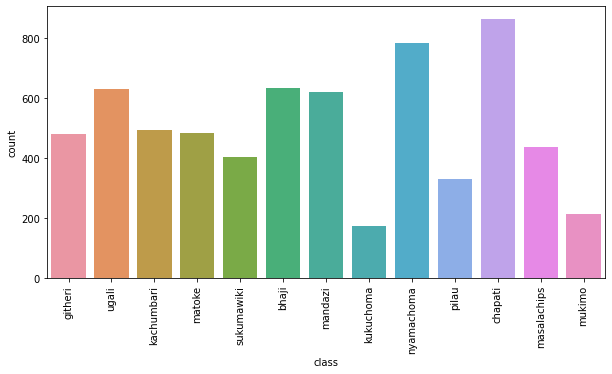

In [4]:
# Plotting the class distribution in training data
plt.figure(figsize = (10,5))
sns.countplot(x = 'class', data = train_data)
plt.xticks(rotation = 90)
plt.show()

In [5]:
# Label Encoder function
def label_encoder(df):
    if df["class"] == 'githeri' :
        return 0
    
    elif df["class"] == 'ugali' :
        return 1
    
    elif df["class"] == 'kachumbari' :
        return 2
    
    elif df["class"] == 'matoke':
        return 3
    
    elif df["class"] == 'sukumawiki':
        return 4
    
    elif df['class'] == 'bhaji':
        return 5
    
    elif df['class'] == 'nyamachoma':
        return 6
    
    elif df['class'] == 'mandazi':
        return 7
    
    elif df['class'] == 'pilau':
        return 8
    
    elif df['class'] == 'chapati':
        return 9
    
    elif df['class'] == 'kukuchoma':
        return 10
    
    elif df['class'] == 'masalachips':
        return 11
    
    elif df['class'] == 'mukimo':
        return 12

In [6]:
# Adding labels column 
train_data['labels'] = train_data.apply(label_encoder, axis = 1)
train_data["id"] = train_data["id"].astype(str)
print(train_data)

                        id       class  labels
0     14278962987112149800     githeri       0
1     13190220095752321996       ugali       1
2     10431803432626641638  kachumbari       2
3      4222441716327528413     githeri       0
4      2547906925836120627      matoke       3
...                    ...         ...     ...
6531   9491780363201908054      matoke       3
6532    938716700684692863     chapati       9
6533  12487998559342412135       ugali       1
6534   3466916091782561952  kachumbari       2
6535   4410319397208590457     chapati       9

[6536 rows x 3 columns]


In [7]:
# converting pandas dataframe to csv
train_data.to_csv("train.csv")

In [8]:
# Custom dataloader function
class Kenyafood_data(Dataset):
    def __init__(self, csv_file, root_dir, transform):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations['id'])
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, str(self.annotations['id'][index])+'.jpg')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        y_label = torch.tensor(int(self.annotations['labels'][index]))
        
        if self.transform is not None:
            image = self.transform(image = image)['image']
            
        return image, y_label

In [9]:
# Necessary transformations for training data
transformations = A.Compose([A.OneOf([
                                      A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.6), 
                                      A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8))
                                     ], p=1),                                
                                A.OneOf([
                                    A.Rotate(limit = 40, p = 0.7),
                                    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.4),
                                    A.MedianBlur(blur_limit=7, always_apply=False, p=0.4),
                                ], p = 1.0),
                             
                                A.OneOf([
                                    A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.4),
                                    A.VerticalFlip(p = 0.7),
                                ], p =1.0),
                                 
                                A.OneOf([
                                    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
                                    A.HorizontalFlip(p = 0.7),
                                ], p = 1.0),
                                
                                A.OneOf([
                                    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.4),
                                    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.6),
                                ], p=1.0),
                                
                                A.OneOf([
                                    A.Posterize(num_bits=4, always_apply=False, p=0.6),
                                    A.FancyPCA(alpha=0.1, always_apply=False, p=0.4),
                                ], p = 1.0),
                             
                                A.OneOf([
                                    A.Solarize(threshold=128, always_apply=False, p=0.7),
                                    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.3),
                                ], p = 1.0),
                             
                                A.Resize(width = 380, height = 380),
                                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                                ToTensorV2()
                        ])


In [10]:
# Splitting training and validation samples
imageloader = Kenyafood_data(csv_file = "./train.csv", root_dir = "../input/opencv-pytorch-dl-course-classification/images/images",
                                          transform = transformations)
train_sampler, val_sampler =  random_split(imageloader, [5228,1308]) 

In [11]:
# Creating dataloader for training and validation samples
train_samples = DataLoader(train_sampler, batch_size = 16, num_workers = 0, shuffle = True)
val_samples = DataLoader(val_sampler, batch_size = 16, num_workers = 0, shuffle = True)

In [12]:
# Checking the dataloader before training
j = next(iter(train_samples))
print(j[0].size())
print(len(train_samples))

torch.Size([16, 3, 380, 380])
327


In [13]:
# Visualizing random images from the training set
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(200, 100))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [14]:
# Defining make_grid function
def make_grid(images, nrow=8, padding=2,
              normalize=False, range=None, scale_each=False, pad_value=0):
    if torch.is_tensor(images):
        grid = torchvision.utils.make_grid(images, nrow=nrow, padding=padding, normalize=normalize, range=range, scale_each=scale_each, pad_value=pad_value)
    else:
        raise TypeError('images should be Tensor')
    return grid

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


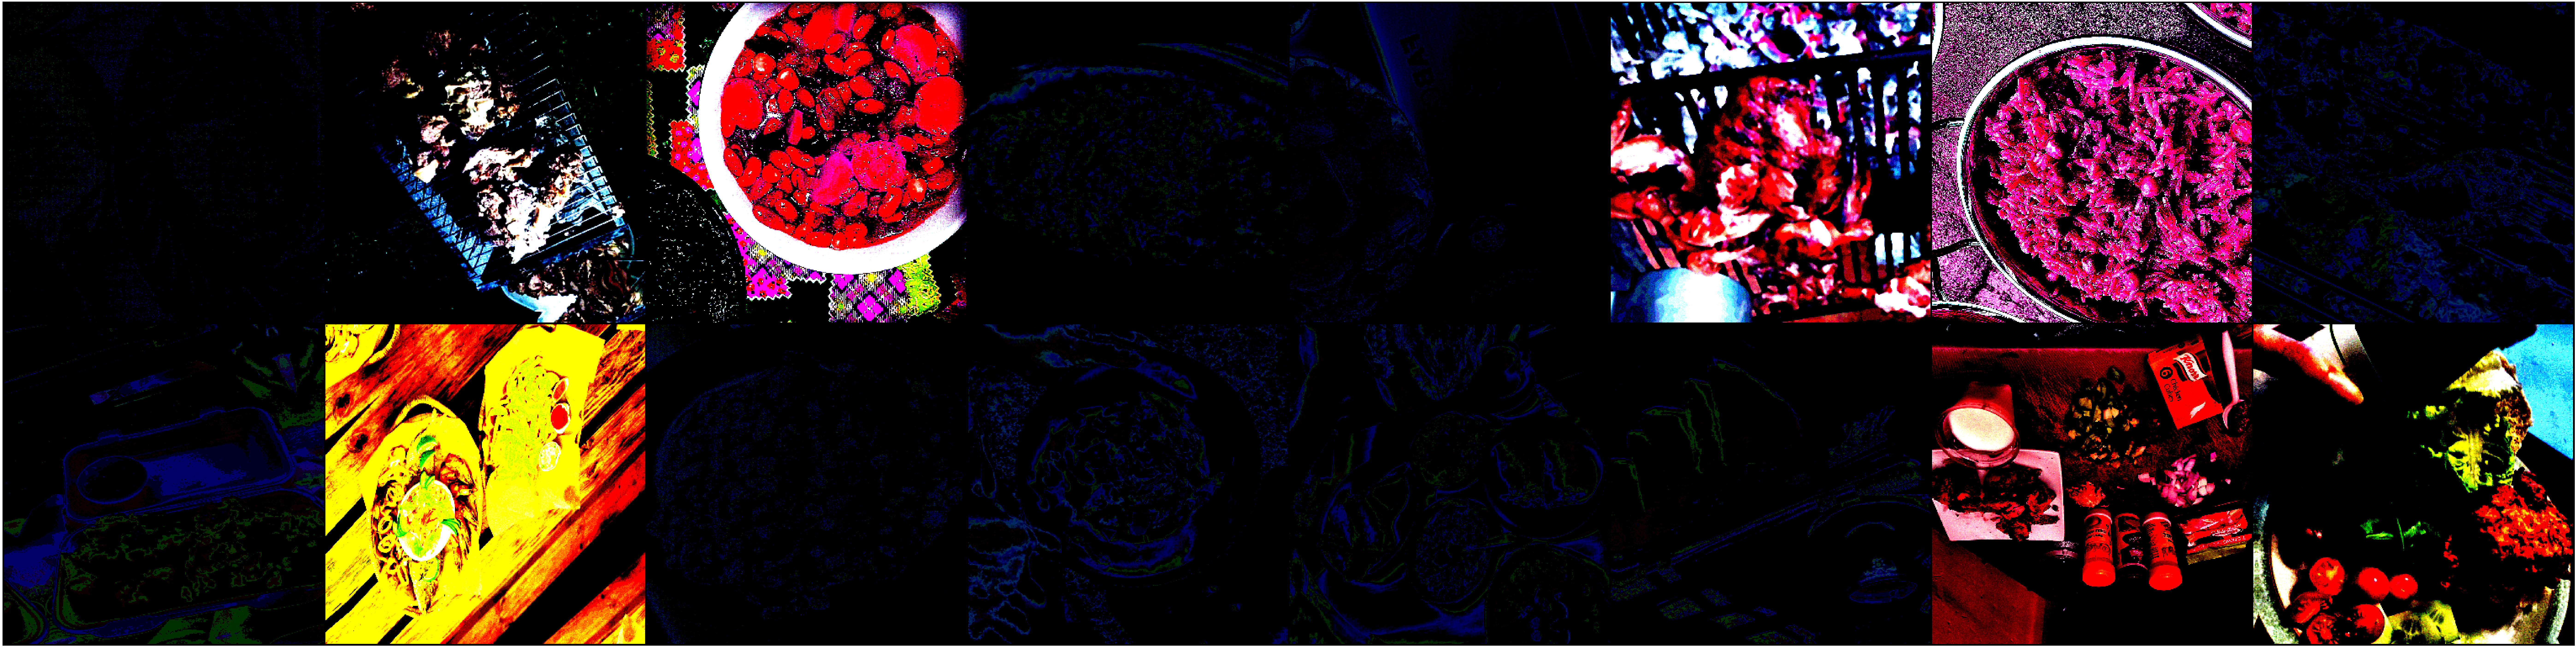

In [15]:
# Visualizing images from the training set
show_batch(train_samples)

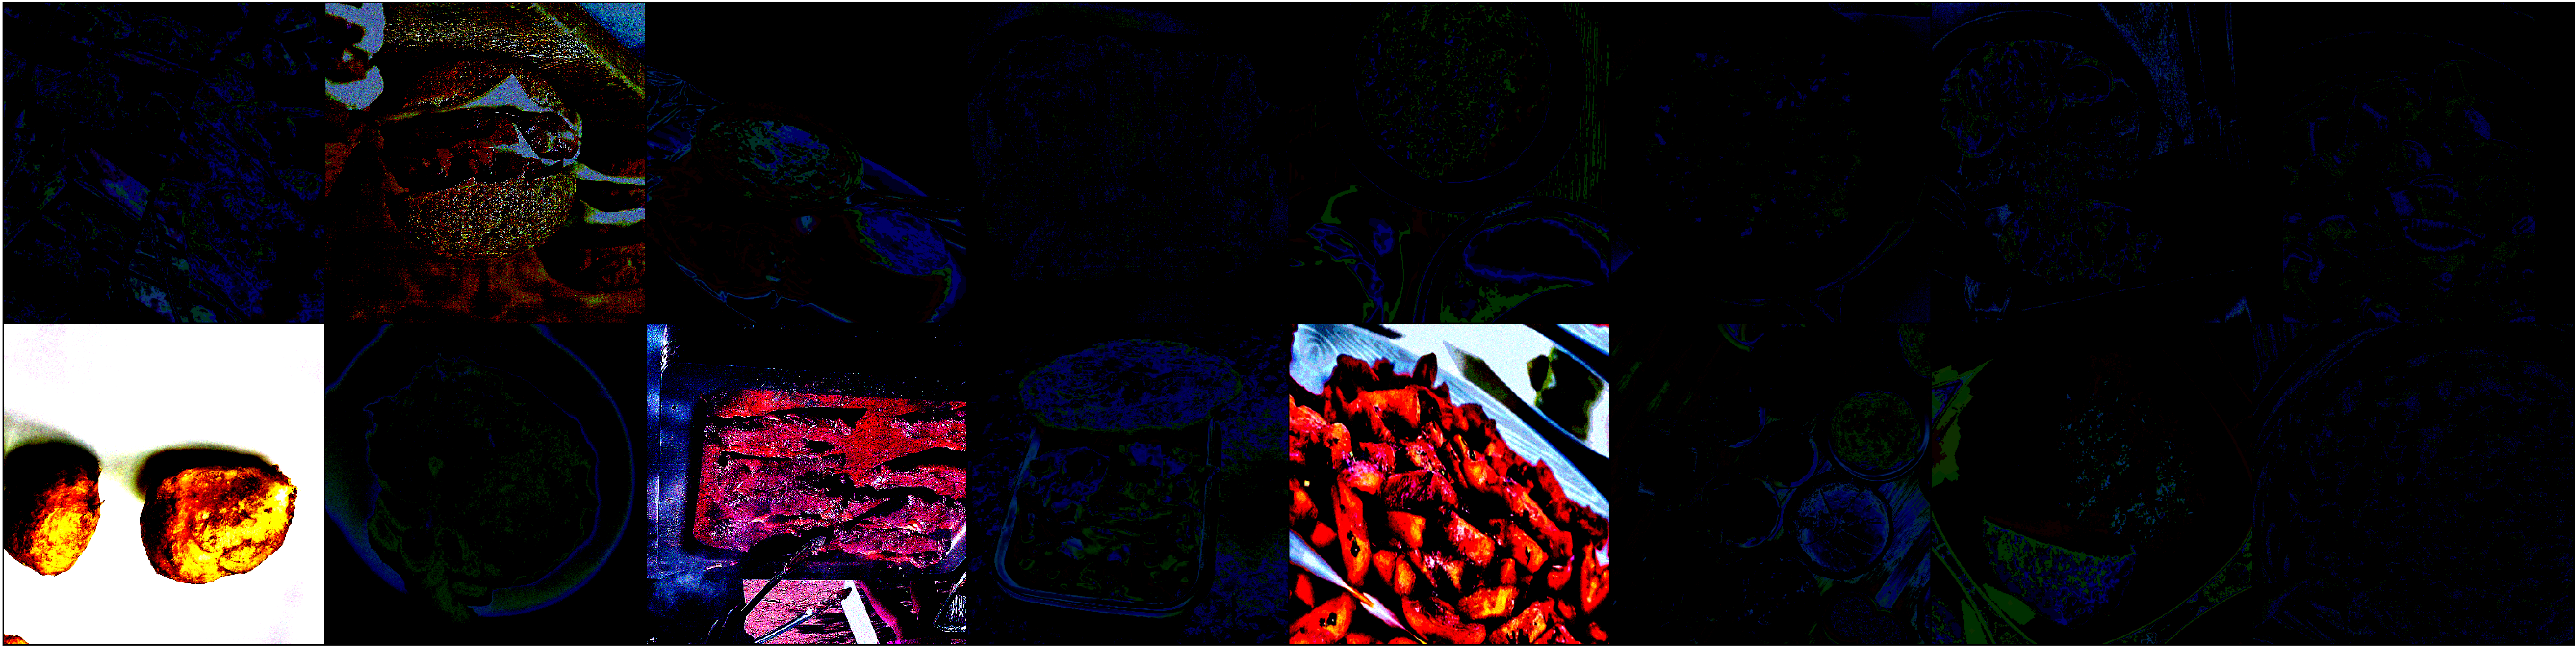

In [16]:
# Visualizing images from the validation set
show_batch(val_samples)

In [17]:
# Loading pre-trained model efficient_b4 model
res_model = models.efficientnet_b4(pretrained = True)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

In [18]:
# Checking the classifier section
res_model.classifier


Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=1000, bias=True)
)

In [19]:
# Changing the final classification head.
res_model.classifier[1] = nn.Linear(in_features=1792, out_features=13)

In [20]:
# Double checking the classifier layer
res_model.classifier


Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=13, bias=True)
)

In [21]:
# Evaluating Accuracy function
def accuracy_score(predictions, labels):
    return (predictions.argmax(dim = 1) == labels).float().mean().item()


In [22]:
# Training function
optimizer = optim.Adam(res_model.parameters(), lr=1e-3, eps=1e-08)
criterion = nn.CrossEntropyLoss()
model = res_model

def Train():
    
    loss_list = []
    acc_list = []
    
    model.cuda()
    model.train()

    for i, (images, labels) in enumerate(train_samples):
        images = images.cuda()

        labels = labels.cuda()

        optimizer.zero_grad()

        prediction = model(images)

        loss = criterion(prediction, labels)

        loss.backward()

        optimizer.step()
                
        prob = F.softmax(prediction, dim = 1)

        loss_list.append(loss.item()) 

        acc = accuracy_score(prob, labels)
        acc_list.append(acc)


    final_loss = sum(loss_list)/len(loss_list)
    final_acc = sum(acc_list)/len(acc_list)

    return final_loss, final_acc
        

In [23]:
# Validation function
def Val():

    acc_list = []
    loss_list = []

    model.eval()
    model.cuda()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_samples):
            images = images.cuda()

            labels = labels.cuda()

            prediction = model(images)

            prob = F.softmax(prediction, dim = 1)

            loss = criterion(prediction, labels)

            loss_list.append(loss.item())

            acc = accuracy_score(prob, labels)
            acc_list.append(acc)


    final_loss = sum(loss_list)/len(loss_list)
    final_acc = sum(acc_list)/len(acc_list)
        
    return final_loss, final_acc

In [24]:
# Training the model
best_acc = 0

train_acc_list = []
val_acc_list = []
train_lss = []
val_lss = []

for i in range(15):
    train_loss, train_acc = Train()
    print('Epoch: {} \t train Loss: {:.4f} \t train Accuracy: {:.4f}'.format(i, train_loss, train_acc*100))
    val_loss, val_acc = Val()
    print('Epoch: {} \t val Loss: {:.4f} \t val Accuracy: {:.4f}'.format(i, val_loss, val_acc*100))

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_lss.append(train_loss)    
    val_lss.append(val_loss)    
    
    if best_acc < val_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), './model.pth')
        print('Saved model')




Epoch: 0 	 train Loss: 1.5264 	 train Accuracy: 51.5482
Epoch: 0 	 val Loss: 0.9924 	 val Accuracy: 68.4705
Saved model
Epoch: 1 	 train Loss: 1.0567 	 train Accuracy: 66.1379
Epoch: 1 	 val Loss: 0.9729 	 val Accuracy: 68.6738
Saved model
Epoch: 2 	 train Loss: 0.9007 	 train Accuracy: 70.0943
Epoch: 2 	 val Loss: 0.8718 	 val Accuracy: 71.2907
Saved model
Epoch: 3 	 train Loss: 0.7668 	 train Accuracy: 75.2612
Epoch: 3 	 val Loss: 0.8382 	 val Accuracy: 72.7896
Saved model
Epoch: 4 	 train Loss: 0.6711 	 train Accuracy: 78.0071
Epoch: 4 	 val Loss: 0.8739 	 val Accuracy: 74.0854
Saved model
Epoch: 5 	 train Loss: 0.6222 	 train Accuracy: 78.7717
Epoch: 5 	 val Loss: 0.9010 	 val Accuracy: 71.7734
Epoch: 6 	 train Loss: 0.5594 	 train Accuracy: 81.3010
Epoch: 6 	 val Loss: 0.9199 	 val Accuracy: 72.4339
Epoch: 7 	 train Loss: 0.5223 	 train Accuracy: 82.3203
Epoch: 7 	 val Loss: 0.9327 	 val Accuracy: 73.2978
Epoch: 8 	 train Loss: 0.4715 	 train Accuracy: 84.1934
Epoch: 8 	 val Loss:

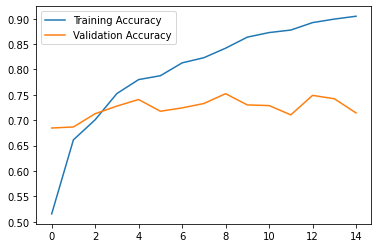

In [25]:
# Plotting the training and validation accuracy
plt.plot(train_acc_list, label = 'Training Accuracy')
plt.plot(val_acc_list, label = 'Validation Accuracy')
plt.legend()
plt.show()


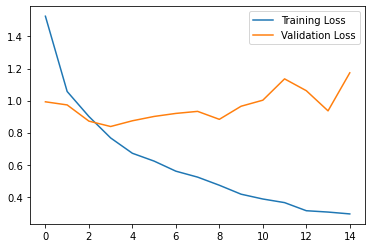

In [26]:
# Plotting the training and validation loss
plt.plot(train_lss, label = 'Training Loss')
plt.plot(val_lss, label = 'Validation Loss')
plt.legend()
plt.show()

In [27]:
# Converting the predicted class to labels
test_data = pd.read_csv('../input/opencv-pytorch-dl-course-classification/test.csv')
test_data['id'] = test_data['id'].astype(str)
test_data["class"] = ""


In [29]:
# Decoding int lables to string labels
def label_decoder(df):
    if df== 0:
        return 'githeri'
    
    elif df == 1:
        return 'ugali'
    
    elif df== 2:
        return 'kachumbari'
    
    elif df == 3:
        return 'matoke'
    
    elif df == 4:
        return 'sukumawiki'
    
    elif df== 5:
        return 'bhaji'
    
    elif df == 6:
        return 'nyamachoma'
    
    elif df == 7:
        return 'mandazi'
    
    elif df== 8 :
        return 'pilau'
    
    elif df== 9:
        return 'chapati'
    
    elif df== 10:
        return 'kukuchoma'
    
    elif df== 11:
        return 'masalachips'
    
    elif df== 12:
        return 'mukimo'

In [30]:
# Testing with unseen data and saving the predictions to submission requirements
def Test():
    model.eval()
    with torch.no_grad():
        trained_model = torch.load('./model.pth')
        model.load_state_dict(trained_model)
        for i in range(len(test_data["id"])):
            img_path = os.path.join('../input/opencv-pytorch-dl-course-classification/images/images', str(test_data["id"][i])+'.jpg')
            image = Image.open(img_path)
            transformer =  transforms.Compose([transforms.Resize((380,380)),transforms.ToTensor(), 
                                          transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
            transformed_image = transformer(image).cuda()
            predictions = model(transformed_image.unsqueeze(0))
            predictions = F.softmax(predictions, dim = 1)
            prediction = predictions.argmax(dim = 1)
            test_data["class"][i] = label_decoder(prediction.item())


    test_data.to_csv('submission.csv', index = False)
    
    

In [31]:
  from ipykernel import kernelapp as app


In [32]:
# Running the test
Test()

In [33]:
def Visualize():
    model.eval()
    with torch.no_grad():
        trained_model = torch.load('./model.pth')
        model.load_state_dict(trained_model)
        fig = plt.figure(figsize = (20,20))
        for i in range(1, 15):
            img_path = os.path.join('../input/opencv-pytorch-dl-course-classification/images/images', str(test_data["id"][i])+'.jpg')
            image = Image.open(img_path)
            transformer =  transforms.Compose([transforms.Resize((380,380)),transforms.ToTensor(), 
                                          transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
            transformed_image = transformer(image).cuda()
            predictions = model(transformed_image.unsqueeze(0))
            predictions = F.softmax(predictions, dim = 1)
            prediction = predictions.argmax(dim = 1)
            ax = fig.add_subplot(5, 5, i)
            ax.set_title(label_decoder(prediction.item()))
            plt.imshow(image)
            plt.axis('off')

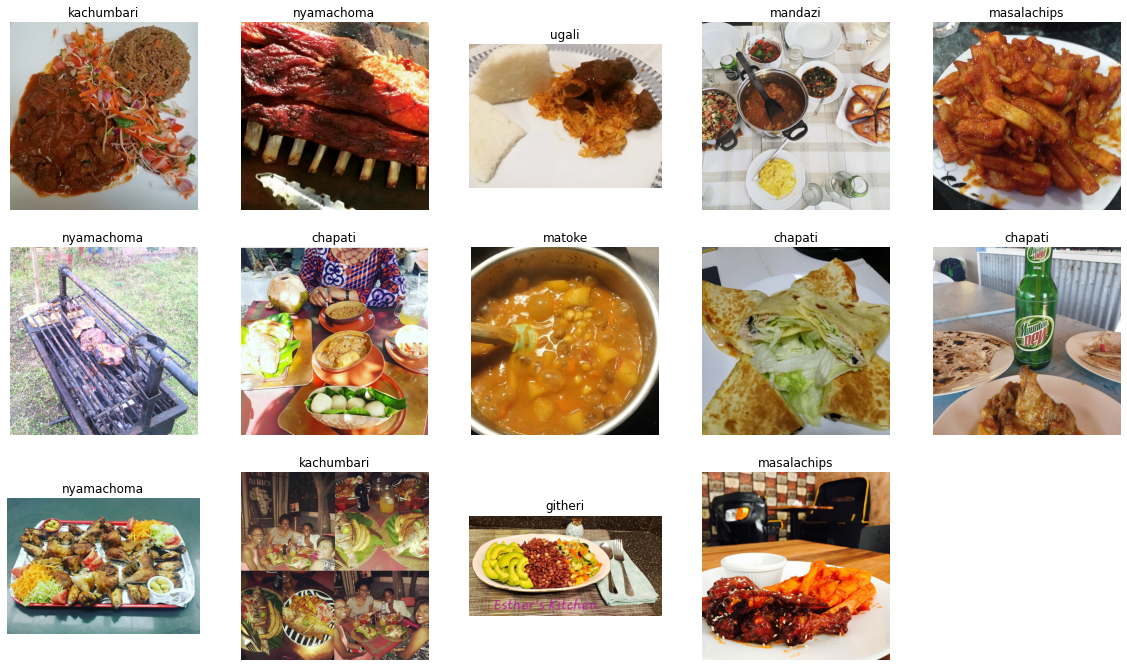

In [34]:
Visualize()

In [35]:
# Comparing train data and test data with respect to the class distribution
def Pie_Chart():
    train_data['class'].value_counts().plot.pie(autopct = '%1.1f%%', figsize = (7,7))
    plt.title('Train Data')
    plt.show()
    test_data['class'].value_counts().plot.pie(autopct = '%1.1f%%', figsize = (7,7))
    plt.title('Test Data')
    plt.show()


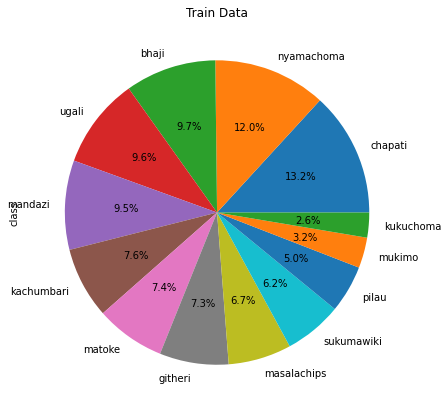

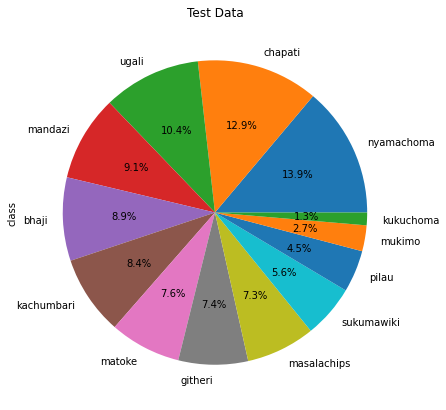

In [36]:
Pie_Chart()